In [ ]:
# 주식 종목 불러오는 패키지
!pip install finance-datareader

In [ ]:
import FinanceDataReader as fdr

In [ ]:
# 삼성전자로 세팅됨, 종목번호 및 기간 바꿔서 진행
df = fdr.DataReader('005930', '2023-07-01', '2024-12-31')
df.tail

<bound method NDFrame.tail of              Open   High    Low  Close    Volume    Change
Date                                                      
2023-07-03  72700  73200  72600  73000  10722181  0.011080
2023-07-04  73400  73600  72900  73000  10214350  0.000000
2023-07-05  73000  73300  71900  72000  12310610 -0.013699
2023-07-06  71900  72400  71500  71600  14777667 -0.005556
2023-07-07  71100  71400  69800  69900  17308877 -0.023743
...           ...    ...    ...    ...       ...       ...
2024-01-17  73100  73300  71000  71000  22683660 -0.022039
2024-01-18  71600  72000  70700  71700  17853397  0.009859
2024-01-19  73500  74700  73000  74700  23363427  0.041841
2024-01-22  75900  76000  75000  75100  19673375  0.005355
2024-01-23  75700  75800  74300  75200  14722676  0.001332

[138 rows x 6 columns]>

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# GPU 꼭 연결해서 사용하세요~!
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

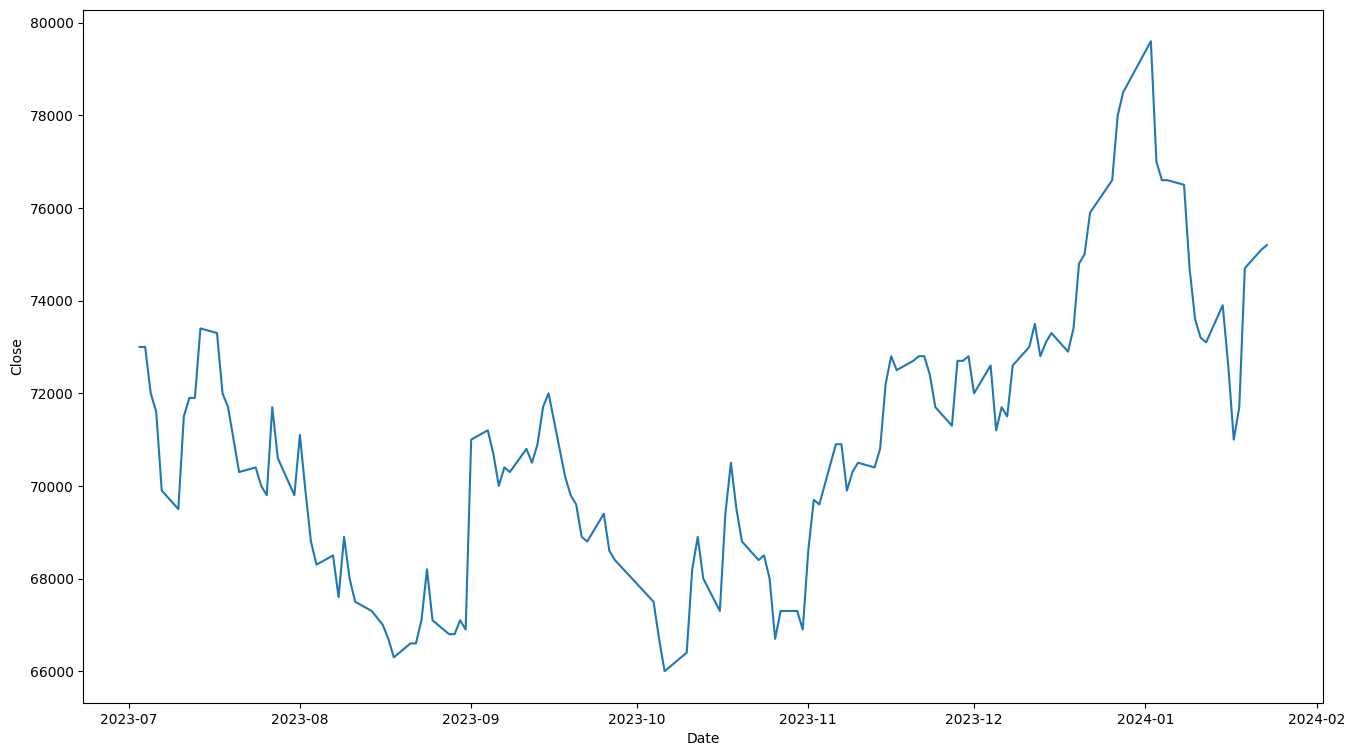

In [ ]:
plt.figure(figsize=(16, 9))
sns.lineplot(x=df.index, y='Close', data=df)
plt.show()

# 데이터 전처리

In [ ]:
#종가 제외 스케일링 (예측변수 = 종가)
scaler = MinMaxScaler()
df[['Open', 'High', 'Low', 'Close', 'Volume']] = scaler.fit_transform(df[['Open','High', 'Low','Close','Volume']])

In [ ]:
#넘파이 배열로 변경
x = df[['Open', 'High', 'Low', 'Volume']].values
y = df['Close'].values

#시퀀스 데이터 생성
def seq_data(x, y, sequence_length):
  x_seq = []
  y_seq = []
  for i in range(len(x) - sequence_length):
    x_seq.append(x[ i : i + sequence_length])
    y_seq.append(y[i + sequence_length])

  #gpu용 텐서로 변환
  return torch.FloatTensor(x_seq).to(device), torch.FloatTensor(y_seq).to(device).view(-1,1)

In [ ]:
split = 70
sequence_length=5 # 5일치씩 묶기
x_seq, y_seq = seq_data(x, y, sequence_length)

#순서대로 70개는 학습, 나머지는 평가
x_train_seq = x_seq[:split]
y_train_seq = y_seq[:split]

x_test_seq = x_seq[split:]
y_test_seq = y_seq[split:]

print(x_train_seq.size(), y_train_seq.size())
print(x_test_seq.size(), y_test_seq.size())

<ipython-input-8-650847349e00>:14: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  return torch.FloatTensor(x_seq).to(device), torch.FloatTensor(y_seq).to(device).view(-1,1)


torch.Size([70, 5, 4]) torch.Size([70, 1])
torch.Size([63, 5, 4]) torch.Size([63, 1])


In [ ]:
x_train_seq

tensor([[[0.5360, 0.4962, 0.5484, 0.0944],
         [0.5920, 0.5267, 0.5726, 0.0846],
         [0.5600, 0.5038, 0.4919, 0.1251],
         [0.4720, 0.4351, 0.4597, 0.1726],
         [0.4080, 0.3588, 0.3226, 0.2214]],

        [[0.5920, 0.5267, 0.5726, 0.0846],
         [0.5600, 0.5038, 0.4919, 0.1251],
         [0.4720, 0.4351, 0.4597, 0.1726],
         [0.4080, 0.3588, 0.3226, 0.2214],
         [0.3200, 0.2824, 0.2742, 0.1135]],

        [[0.5600, 0.5038, 0.4919, 0.1251],
         [0.4720, 0.4351, 0.4597, 0.1726],
         [0.4080, 0.3588, 0.3226, 0.2214],
         [0.3200, 0.2824, 0.2742, 0.1135],
         [0.3360, 0.3664, 0.3468, 0.1225]],

        ...,

        [[0.2080, 0.2290, 0.1935, 0.2600],
         [0.1600, 0.1374, 0.1532, 0.0752],
         [0.1520, 0.1374, 0.0806, 0.1306],
         [0.1360, 0.2443, 0.1290, 0.2212],
         [0.2320, 0.2901, 0.2419, 0.2057]],

        [[0.1600, 0.1374, 0.1532, 0.0752],
         [0.1520, 0.1374, 0.0806, 0.1306],
         [0.1360, 0.2443, 0.1290

In [ ]:
train = torch.utils.data.TensorDataset(x_train_seq, y_train_seq)
test = torch.utils.data.TensorDataset(x_test_seq, y_test_seq)

batch_size = 5
train_loader = torch.utils.data.DataLoader(dataset=train, batch_size = batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test, batch_size = batch_size)

# Vanila RNN
## 모델 구축

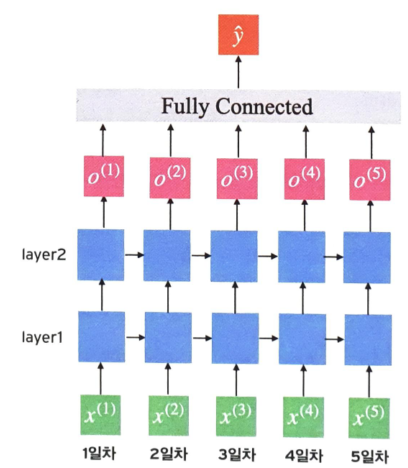

In [ ]:
#기본 하이퍼 파라미터 설정
input_size = x_seq.size(2)
num_layers = 2
hidden_size = 8

In [ ]:
class VanillaRNN(nn.Module):
  def __init__(self, input_size, hidden_size, sequence_length, num_layers, device):
    super(VanillaRNN, self).__init__()
    self.device = device
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True) #한 줄로 모델 정의
    self.fc = nn.Sequential(nn.Linear(hidden_size * sequence_length, 1), nn.Sigmoid()) #RNN 층에서 나온 결과를 fc 층으로 전달해서 예측값 계산

  def forward(self, x):
    h0 = torch.zeros(self.num_layers, x.size()[0], self.hidden_size).to(self.device) #초기값 0으로 설정
    out,_ = self.rnn(x, h0)  #x와 h0(초기 은닉상태)가 RNN의 input으로 들어감. RNN 셀 통과
    out = out.reshape(out.shape[0], -1)  #fc layer에 입력하기 위해 데이터의 차원 flatten
    out = self.fc(out)   #fc layer
    return out

In [ ]:
model = VanillaRNN(input_size=input_size,
                   hidden_size = hidden_size,
                   sequence_length=sequence_length,
                   num_layers=num_layers,
                   device=device).to(device)

In [ ]:
criterion = nn.MSELoss()
num_epochs = 50
optimizer = optim.Adam(model.parameters(), lr=1e-3)

## 모델 학습

In [ ]:
loss_graph = []
n = len(train_loader)

for epoch in range(num_epochs):
  running_loss = 0

  for data in train_loader:
    seq, target = data #배치 데이터
    out = model(seq) #출력값 계산
    loss = criterion(out, target) #손실함수 계산

    optimizer.zero_grad()
    loss.backward()
    optimizer.step() #최적화
    running_loss += loss.item()

  loss_graph.append(running_loss/n)
  if epoch % 10 ==0:
    print('[epoch : %d] loss: %.4f' %(epoch, running_loss/n))

[epoch : 0] loss: 0.0849
[epoch : 10] loss: 0.0182
[epoch : 20] loss: 0.0158
[epoch : 30] loss: 0.0117
[epoch : 40] loss: 0.0106


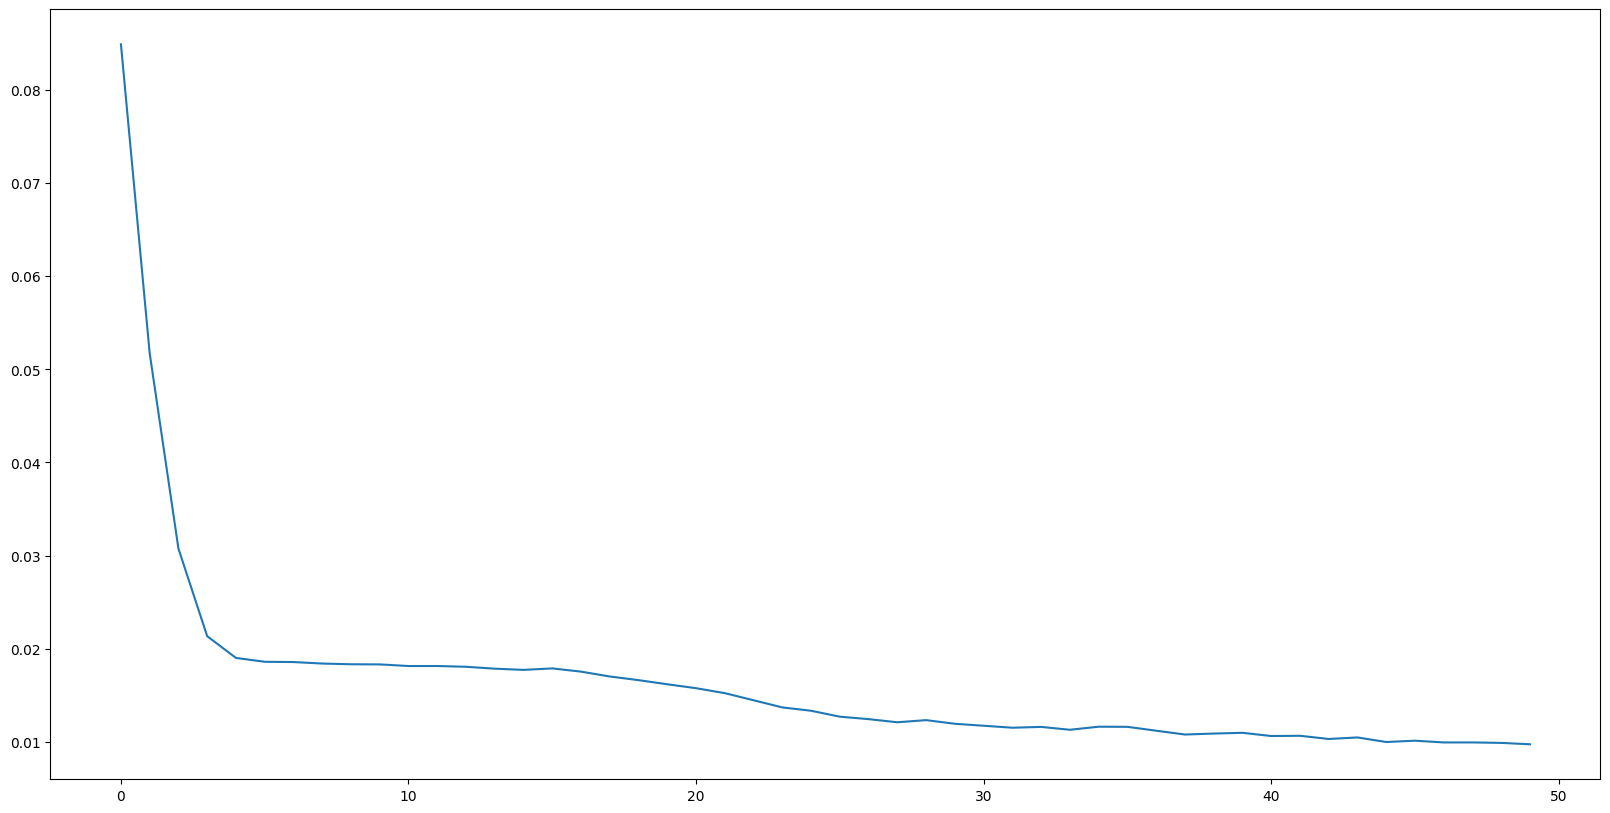

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(loss_graph)
plt.show()

## 실제값과 예측값 비교

In [ ]:
concatdata = torch.utils.data.ConcatDataset([train, test])
data_loader = torch.utils.data.DataLoader(dataset = concatdata, batch_size = 100)

with torch.no_grad():
  pred = []
  model.eval()
  for data in data_loader:
    seq, target = data
    out = model(seq)
    pred += out.cpu().tolist()

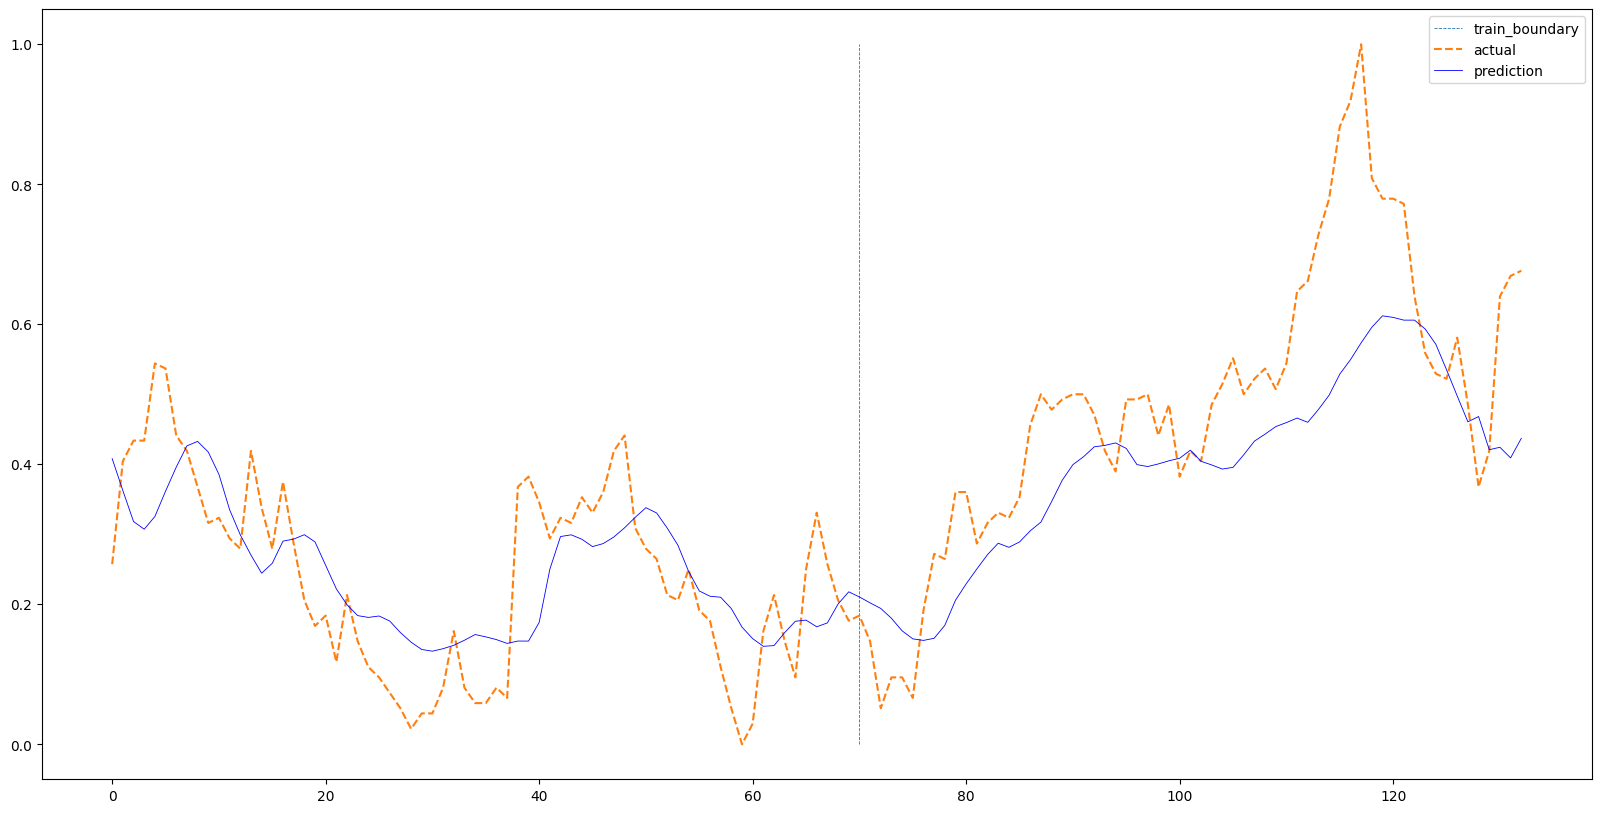

In [ ]:
plt.figure(figsize = (20,10))
plt.plot(np.ones(100)*len(train), np.linspace(0,1,100), '--', linewidth=0.6)
plt.plot(df['Close'][sequence_length:].values,'--')
plt.plot(pred, 'b', linewidth = 0.6)
plt.legend(['train_boundary','actual','prediction'])
plt.show()

# LSTM
## 모델구축

In [ ]:
#하이퍼 파라미터 정의
input_size = x_seq.size(2)
num_layers = 2
hidden_size = 8

In [ ]:
class LSTM(nn.Module):
  def __init__(self, input_size, hidden_size, sequence_length, num_layers, device):
    super(LSTM, self).__init__()
    self.device = device
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first = True)
    self.fc = nn.Linear(hidden_size*sequence_length ,1)

  def forward(self, x):
    h0 = torch.zeros(self.num_layers, x.size()[0], self.hidden_size).to(self.device)
    c0 = torch.zeros(self.num_layers, x.size()[0], self.hidden_size).to(self.device)
    out, _ = self.lstm(x,(h0,c0)) #x와 h0(초기 은닉상태), c0(초기 셀상태)가 RNN의 input으로 들어감. RNN 셀 통과
    out = out.reshape(out.shape[0], -1) #fc layer에 입력하기 위해 데이터의 차원 flatten
    out = self.fc(out)  #fc layer
    return out

In [ ]:
model = LSTM(input_size = input_size,
             hidden_size=hidden_size,
             sequence_length=sequence_length,
             num_layers = num_layers,
             device=device).to(device)

In [ ]:
criterion = nn.MSELoss()
num_epochs =50
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
loss_graph = []
n = len(train_loader)

for epoch in range(num_epochs):
    running_loss = 0.0

    for data in train_loader:

        seq, target = data # 배치 데이터
        out = model(seq)
        loss = criterion(out, target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    loss_graph.append(running_loss/n)
    if epoch % 10 == 0:
        print('[epoch: %d] loss: %.4f' %(epoch, running_loss/n))


[epoch: 0] loss: 0.0522
[epoch: 10] loss: 0.0174
[epoch: 20] loss: 0.0118
[epoch: 30] loss: 0.0111
[epoch: 40] loss: 0.0107


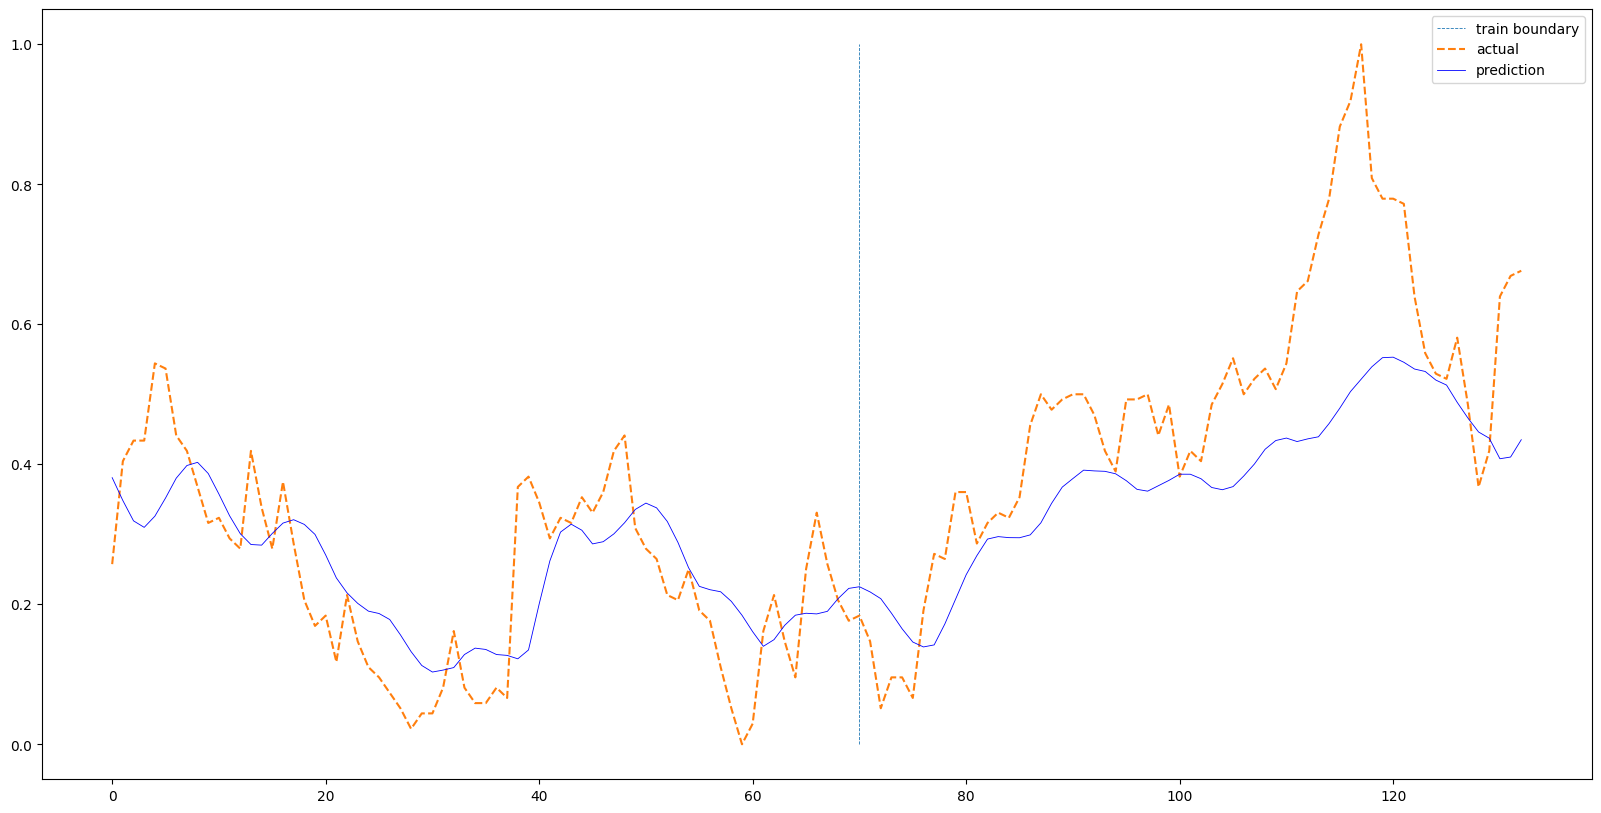

In [ ]:
concatdata = torch.utils.data.ConcatDataset([train, test])
data_loader = torch.utils.data.DataLoader(dataset=concatdata, batch_size=100, shuffle=False)

with torch.no_grad():
    pred = []
    model.eval()
    for data in data_loader:
        seq, target = data
        out = model(seq)
        pred += out.cpu().tolist()

plt.figure(figsize=(20,10))
plt.plot(np.ones(100)*len(train),np.linspace(0,1,100),'--', linewidth=0.6)
plt.plot(df['Close'][sequence_length:].values,'--')
plt.plot(pred,'b', linewidth=0.6)
plt.legend(['train boundary','actual','prediction'])
plt.show()